In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torchvision.datasets import EMNIST


def plot_client_data(settings_ids, dataset, model, n_clients, dist):
    train_data = EMNIST(root='data', train=True, split="letters")
    fig, ax = plt.subplots(len(settings_ids), 1, figsize=(16, 10))

    for j, settings_id in enumerate(settings_ids):

        settings_path = f"./settings/{dataset}_{model}_c{n_clients}_{dist}_{settings_id}"
        local_indices = []
        with open(f"{settings_path}/data_splits.npy", "rb") as f:
            public_indices = np.load(f)
            try:
                while True:
                    local_indices.append(np.load(f))
            except:
                pass
        
        client_targets = [train_data.targets[indices].tolist() for indices in local_indices]
        n_clients = len(client_targets)
        n_classes = 10

        label_count_matrix = np.array([[np.sum(np.array(client_targets[i]) == c) for c in range(10)] for i in range(n_clients)])
        data_dict = {}
        for i in range(n_classes):
            data_dict[f"label_count{i}"] = label_count_matrix[:, i]

        df = pd.DataFrame(data_dict)

        df.plot(ax=ax[j], kind='bar', stacked=True, rot=0)
        ax[j].get_legend().remove()
    #ax[0].legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], mode="expand", ncol=10, bbox_to_anchor=(0,1.02,1,0.15), loc="upper left")
    plt.show()

def plot_test_public_data(settings_ids, dataset, model, n_clients, dist):

    settings_path = f"./settings/{dataset}_{model}_c{n_clients}_{dist}_{settings_ids[0]}"
    with open(f"{settings_path}/data_splits.npy", "rb") as f:
        public_indices = np.load(f)

    test_data = EMNIST(root='data', train=False, split="letters")
    train_data = EMNIST(root='data', train=True, split="letters")
    test_public_targets = [test_data.targets.tolist()]
    test_public_targets.append(train_data.targets[public_indices].tolist())
    
    n_classes = 26
    label_count_matrix = np.array([[np.sum(np.array(targets) == c) for c in range(n_classes)] for targets in test_public_targets])

    data_dict = {}
    for i in range(n_classes):
        data_dict[f"label_count{i}"] = label_count_matrix[:, i]

    fig, ax = plt.subplots(figsize=(12, 8))
    df = pd.DataFrame(data_dict, index=["Test data", "Public data"])
    df.plot(ax=ax, kind='bar', stacked=True, rot=0)
    #ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], mode="expand", ncol=10, bbox_to_anchor=(0,1.01,1,0.1), loc="upper left")
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.show()    

def plot_client_training(settings_ids, dataset, alg, weight_scheme, loss=None, student_model=None):    
    student_model = student_model + "_" if student_model is not None else ""
    loss = loss + "_" if loss is not None else ""
    
    fig, ax = plt.subplots(2, len(settings_ids), figsize=(15,6))
    for i, setting_id in enumerate(settings_ids):
        results_path = f"./results/{dataset}/{alg}/{setting_id}_{student_model}{loss}w{weight_scheme}"
        client_accs = []
        with open(f"{results_path}/client_accuracy.npy", "rb") as f:
            try:
                while True:
                    client_accs.extend([np.load(f)])
            except:
                pass

        client_losses = []
        with open(f"{results_path}/client_loss.npy", "rb") as f:
            try:
                while True:
                    client_losses.extend([np.load(f)])
            except:
                pass

        for accs in client_accs:
            ax[0][i].plot(accs)

        for losses in client_losses:
            ax[1][i].plot(losses)
    plt.show()  

def plot_student_results(dataset, alg, settings_ids, n_pub, model, loss, weight_scheme):
    fig, ax = plt.subplots(len(settings_ids), len(n_pub), figsize=(20,10))
    test_acc_lists = [[] for _ in range(len(n_pub))]
    ensemble_test_acc = [[] for _ in range(len(settings_ids))]

    for i, setting_id in enumerate(settings_ids):
        results_path = f"./results/{dataset}/{alg}/{setting_id}_{model}_{loss}_w{weight_scheme}"
        for j, n in enumerate(n_pub):
            with open(f"{results_path}/student_train_results{n}.npy", "rb") as f:
                train_accs = np.load(f)
                train_losses = np.load(f)
                val_accs = np.load(f)
                val_losses = np.load(f)

            with open(f"{results_path}/student_test_results_{n}.npy", "rb") as f:
                test_results = np.load(f)

            ax[i][j].plot(train_accs)
            ax[i][j].plot(val_accs)
            ax[i][j].set_ylim([0,100])
            test_acc_lists[j].append(test_results[0])
            
        with open(f"{results_path}/ensemble_test_acc.npy", "rb") as f:
                ensemble_test_acc[i] = np.load(f)[0]
        
    plt.show()
    print("Test accuracy \n\n")
    print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10} | {:<10}".format('Run\Public size', n_pub[0], n_pub[1], n_pub[2], n_pub[3], n_pub[4], 'Ensemble acc'))
    for run in range(len(settings_ids)):
        print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} | {:<10.2f} ".format(run, 
                                                  test_acc_lists[0][run],
                                                  test_acc_lists[1][run],
                                                  test_acc_lists[2][run],
                                                  test_acc_lists[3][run],
                                                               test_acc_lists[4][run],
                                                    ensemble_test_acc[run]))
    print("")
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format('Mean',
                                                     np.mean(test_acc_lists[0]),
                                                     np.mean(test_acc_lists[1]),
                                                     np.mean(test_acc_lists[2]),
                                                     np.mean(test_acc_lists[3]),
                                                                np.mean(test_acc_lists[4])))

def print_test_results(settings_files, alg):    
    #fig, ax = plt.subplots(1, 2, figsize=(15,6))
    dataset = settings_files[0].split('_')[0]
    test_acc_list = []
    for i, set in enumerate(settings_files):
        results_path = f"./results/{dataset}/{alg}/{set}_w0"

        with open(f"{results_path}/fedavg_test_results.npy", "rb") as f:
            test_accs = np.load(f)
            test_losses = np.load(f)

        #ax[0].plot(test_accs)
        #ax[1].plot(test_losses)
        test_acc_list.append(test_accs[-1])
    # ax[0].set_ylabel("Accuracy")
    # ax[0].set_xlabel("Communication round")
    # ax[1].set_ylabel("Loss")
    # ax[1].set_xlabel("Communication round")
    #plt.show()
    # print("{:<8} {:<10}".format('Run', 'Test accuracy'))
    # for run in range(len(settings_files)):
    #     print("{:<8} {:<10}".format(run, test_acc_list[run]))
    # print("")
    # print("{:<8} {:<10.2f}".format('Mean', np.mean(test_acc_list)))
    # print("{:<8} {:<10.2f}".format('Std', np.std(test_acc_list)))

    return np.mean(test_acc_list), np.std(test_acc_list)

def print_feded_results(settings_files, n_pub, model, loss, weight_scheme):

    test_acc_lists = []
    ensemble_test_acc = []
    dataset = settings_files[0].split('_')[0]

    for i, set in enumerate(settings_files):
        results_path = f"./results/{dataset}/feded/{set}_{model}_{loss}_w{weight_scheme}"

        with open(f"{results_path}/student_test_results_{n_pub}.npy", "rb") as f:
            test_acc_lists.append(np.load(f)[0])

            
        with open(f"{results_path}/ensemble_test_acc.npy", "rb") as f:
            ensemble_test_acc.append(np.load(f)[0])
        
    return (np.mean(test_acc_lists), np.std(test_acc_lists)), (np.mean(ensemble_test_acc), np.std(ensemble_test_acc))
        

# Data distribution

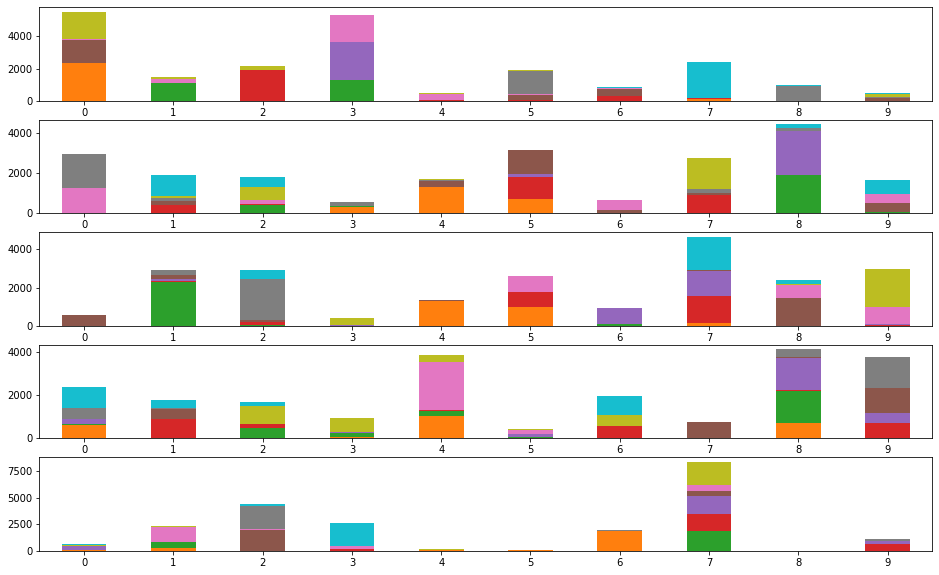

In [4]:
plot_client_data(settings_ids, "emnist", "cnn1", 10, distribution)

# FedAVG
```
class Emnist_Cnn1(nn.Module):
    def __init__(self):
        super(Emnist_Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 5, 1, 2)
        self.pool = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(2 * 7 * 7, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
```

Centralized model ~80 % accuracy

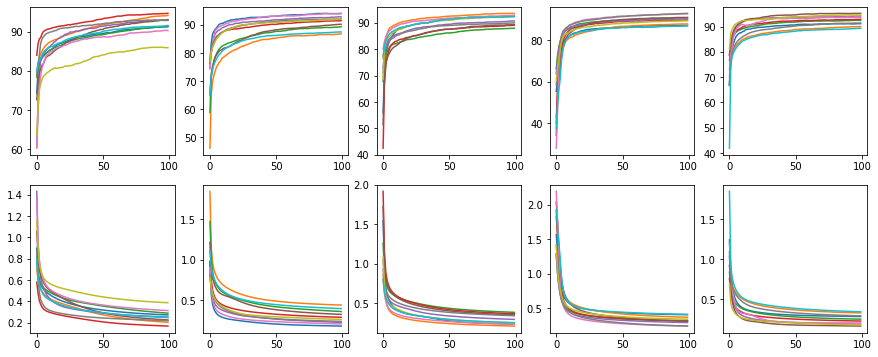

In [6]:
plot_client_training(settings_ids, "emnist", "fedavg", 0)

In [7]:
print_fedavg_test_results("emnist", settings_ids)

Run      Test accuracy
0        71.3076923076923
1        73.625    
2        70.83173076923077
3        71.19711538461539
4        70.32211538461539

Mean     71.46     


# FedED
```
class Emnist_Cnn2(nn.Module):
    def __init__(self):
        super(Emnist_Cnn2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 26)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

        
loss = nn.MSELoss()
```

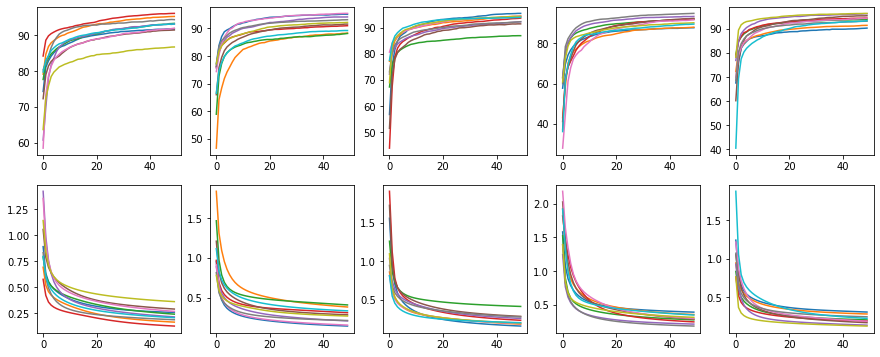

In [12]:
plot_client_training(settings_ids, "emnist", "feded", 0, "mse", "cnn1")

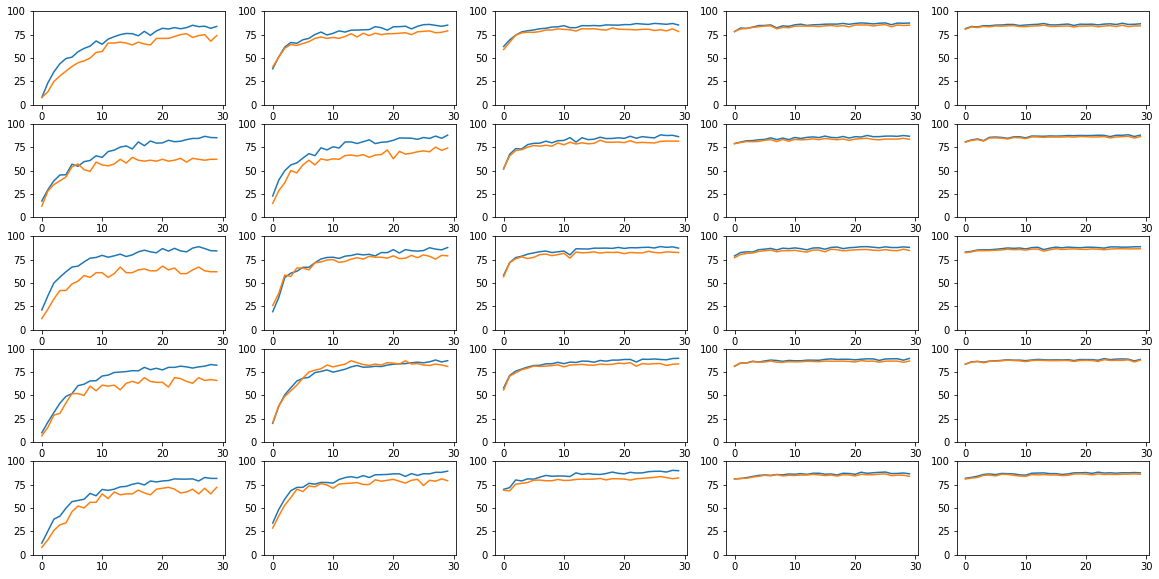

Test accuracy 


Run\Public size 500        1000       5000       30000      60000      | Ensemble acc
0               52.92      59.25      62.65      63.75      65.35      | 63.64      
1               53.91      59.20      66.41      65.82      65.72      | 66.46      
2               55.32      61.79      66.42      67.85      67.91      | 66.82      
3               55.51      60.63      66.63      67.25      67.19      | 67.48      
4               54.39      59.74      62.43      64.20      63.81      | 64.34      

Mean            54.41      60.12      64.91      65.78      66.00     


In [13]:
plot_student_results("emnist", "feded", settings_ids, [500, 1000, 5000, 30000, 60000], "cnn2", "mse", 0)

# FedED weight scheme 1

$$
  \mathbf{\hat{z}}_c = \sum_{k\in\mathcal{K}_t} \omega^c_k \mathbf{z}^k_c, \quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$

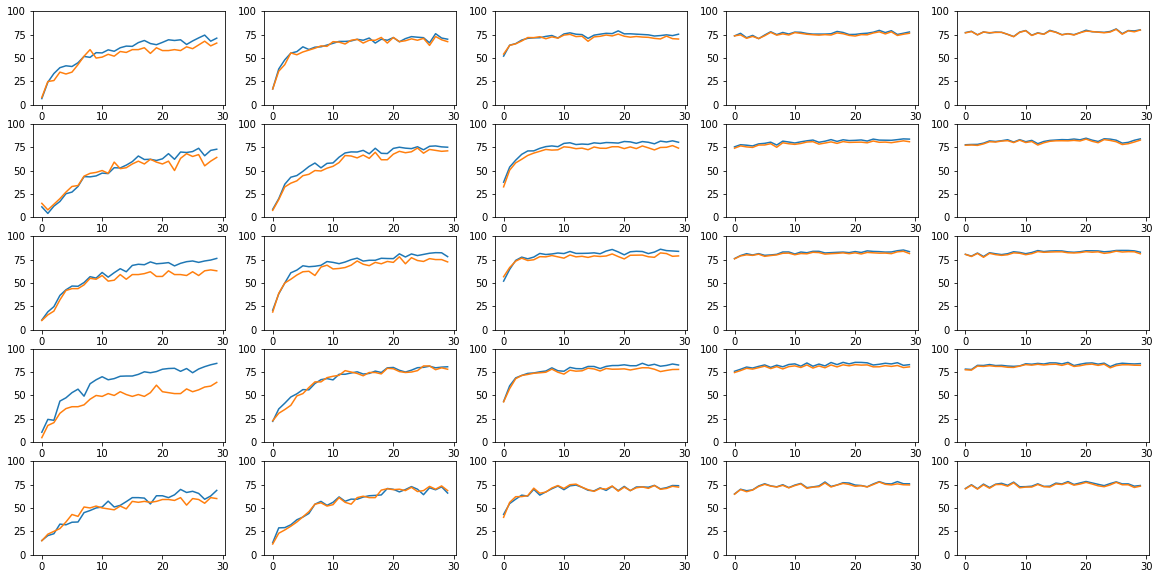

Test accuracy 


Run\Public size 500        1000       5000       30000      60000      | Ensemble acc
0               55.92      60.47      67.36      69.25      70.33      | 69.39      
1               52.36      63.60      67.74      71.99      73.82      | 70.94      
2               60.25      64.72      69.57      72.66      69.45      | 72.54      
3               64.82      69.89      73.46      74.10      74.30      | 73.97      
4               55.00      59.21      67.79      70.23      68.22      | 69.74      

Mean            57.67      63.58      69.18      71.65      71.22     


In [14]:
plot_student_results("emnist", "feded", settings_ids, [500, 1000, 5000, 30000, 60000], "cnn2", "mse", 1)

# FedED weight scheme 2

1. Träna autoencoder $H_k$ på privat data $\mathcal{D}_k$.
2. För varje publikt dataexempel $x_j$, notera loss
$$ l_k(x_j) = MSE(H_k(x_j), x_j). $$
3. Ange vikt 
$$\omega^j_k = \frac{1}{l_k(x_j)^6}.$$
3. Bilda viktat medelvärde för logits med aktiva klienter $\mathcal{K}_t$
$$
  \mathbf{\hat{z}}_j = \sum_{k\in\mathcal{K}_t} \omega^j_k \mathbf{z}^j_k. %\quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$
4. Normalisera.

Student loss: 
$$\mathbf{z}_j = F_S(x_j) \qquad MSE(\mathbf{z}_j, \mathbf{\hat{z}}_j)$$

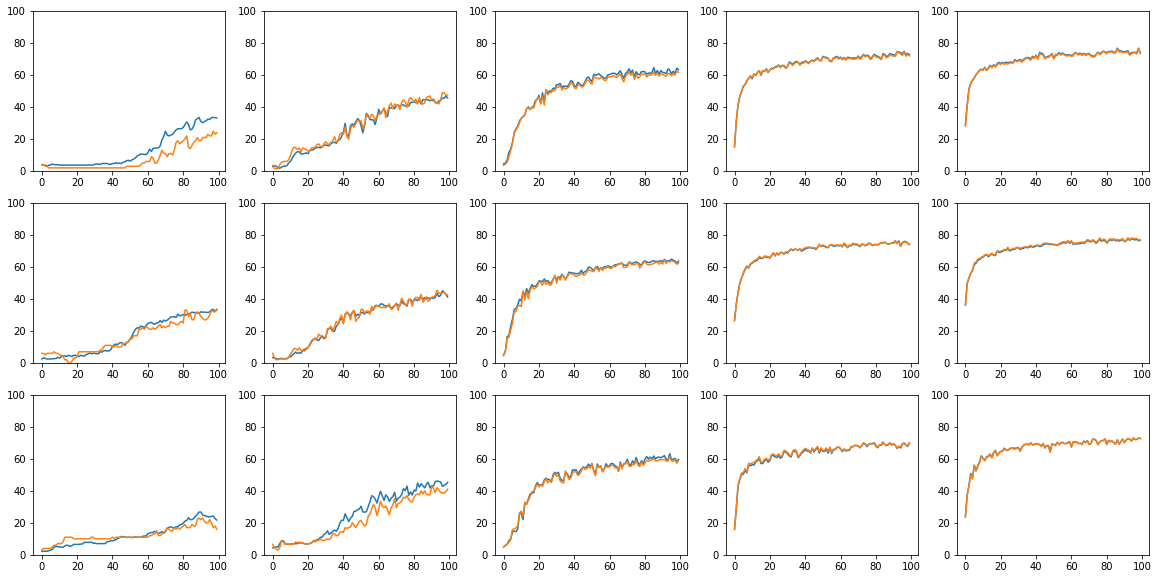

Test accuracy 


Run\Public size 500        1000       5000       30000      60000      | Ensemble acc
0               23.39      37.66      55.80      64.38      65.29      | 82.04      
1               23.95      35.69      54.25      63.82      65.66      | 80.90      
2               12.63      35.55      49.60      59.84      62.48      | 81.10      

Mean            19.99      36.30      53.21      62.68      64.48     


In [53]:
plot_student_results("emnist", "feded", settings_ids, [500, 1000, 5000, 30000, 60000], "cnn2", "mse", 2)

## Improvement

Student loss: 
$$CE(\mathbf{t}_j, \mathbf{\hat{t}}_j)$$

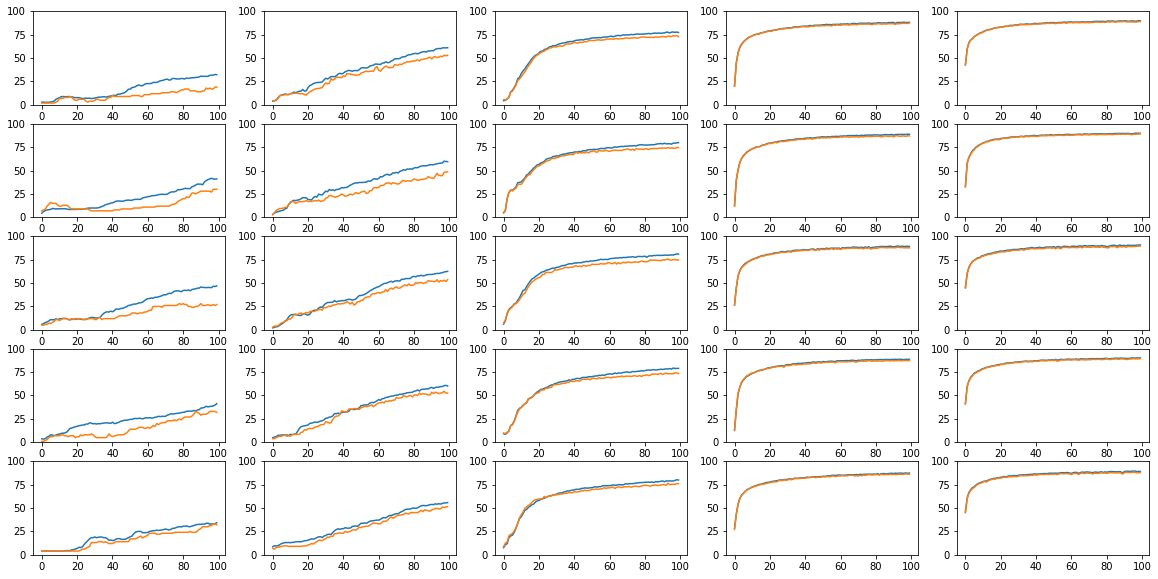

Test accuracy 


Run\Public size 500        1000       5000       30000      60000      | Ensemble acc
0               19.44      46.80      66.76      80.31      80.46      | 81.63      
1               25.51      46.71      67.64      78.39      80.14      | 81.04      
2               30.06      47.45      68.91      80.12      81.77      | 81.87      
3               25.63      47.53      68.10      78.90      81.09      | 81.22      
4               22.55      44.06      67.14      78.00      79.24      | 81.03      

Mean            24.64      46.51      67.71      79.14      80.54     


In [55]:
settings_ids = ["aln", "nod", "xjr", "zex", "zft"]
plot_student_results("emnist", "feded", settings_ids, [500, 1000, 5000, 30000, 60000], "cnn2", "ce", 2)